In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013.csv


## Import một số thư viện cần thiết

In [2]:
!pip install --upgrade timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torchvision import transforms
import timm  # EfficientNetB4
import warnings
import torch.optim as optim
warnings.filterwarnings('ignore')

## Xử lý dữ liệu

In [ ]:
from scipy.stats import zscore
# 1. Đọc dữ liệu
df = pd.read_csv("/kaggle/input/fer2013.csv")
# 2. Tiền xử lý và thống kê ảnh
# Công thức tương ứng
#pixel_mean = (1/n) * ∑ xᵢ
#pixel_std = sqrt[(1/n) * ∑ (xᵢ - mean)²]
#pixel_min = min(x₁, ..., xₙ)
#pixel_max = max(x₁, ..., xₙ)
df['pixels_array'] = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=np.float32))
df['pixel_mean'] = df['pixels_array'].apply(np.mean)
df['pixel_std'] = df['pixels_array'].apply(np.std)
df['pixel_min'] = df['pixels_array'].apply(np.min)
df['pixel_max'] = df['pixels_array'].apply(np.max)
# 3. Gắn cờ ảnh mờ & nhiễu
# Note: Ảnh mờ có độ sáng thấp (mean<40) và ít thay đổi về pixel (std<15)
        #Ảnh nhiễu có độ pixel cao >70
df['is_blurred'] = (df['pixel_mean'] < 40) & (df['pixel_std'] < 15)
df['is_noisy'] = df['pixel_std'] > 70
# 4. Gắn cờ ảnh lỗi
# Ảnh được coi là lỗi (corrupted) nếu:
#Gần như toàn đen hoặc toàn trắng (mean quá thấp hoặc quá cao)
#Không có sự khác biệt pixel (std < 5)
#Khoảng dao động pixel rất nhỏ (max - min < 20)
#Toàn ảnh tối (max < 30) hoặc quá sáng (min > 225)
def is_corrupted(row):
    return (
        row['pixel_mean'] < 10 or
        row['pixel_mean'] > 245 or
        row['pixel_std'] < 5 or
        (row['pixel_max'] - row['pixel_min']) < 20 or
        row['pixel_max'] < 30 or
        row['pixel_min'] > 225
    )
df['corrupted'] = df.apply(is_corrupted, axis=1)

# 5. Tính z-score để loại outlier trong mỗi class (dựa vào pixel_mean và pixel_std)
#Z-score = (x - μ) / σ
"""
Trong đó:
x: pixel_mean (hoặc pixel_std) của ảnh
μ: trung bình pixel_mean trong từng emotion
σ: độ lệch chuẩn trong từng emo
"""
df['z_mean'] = df.groupby('emotion')['pixel_mean'].transform(zscore)
df['z_std'] = df.groupby('emotion')['pixel_std'].transform(zscore)

# Đặt ngưỡng loại outlier (ví dụ: z > 2.5)
# Ví dụ cụ thể về outlier
"""
Giả sử trong class "Happy" có:
mean(pixel_mean) = 100, std(pixel_mean) = 20
mean(pixel_std) = 40, std(pixel_std) = 10
→ Một ảnh có:
pixel_mean = 160 → z = (160 - 100) / 20 = +3.0 → outlier
pixel_std = 65 → z = (65 - 40) / 10 = +2.5 → vẫn outlier vì bằng ngưỡng
"""
df['is_outlier'] = (df['z_mean'].abs() > 2.5) | (df['z_std'].abs() > 2.5)

# 6. Giữ lại ảnh sạch
# Điều kiện giữ lại ảnh: Không mờ, lỗi và outlier
clean_df = df[
    (~df['is_blurred']) &
    (~df['corrupted']) &
    (~df['is_outlier'])
].copy().reset_index(drop=True)

# 7. Thống kê
print(f"Số ảnh mờ bị loại:        {df['is_blurred'].sum()}")
print(f"Số ảnh lỗi bị loại:       {df['corrupted'].sum()}")
print(f"Số outlier bị loại:       {df['is_outlier'].sum()}")
print(f"Tổng số ảnh còn lại:      {len(clean_df)}")

# 8. Lưu file CSV mới
clean_df[['emotion', 'pixels', 'Usage']].to_csv("fer2013_new.csv", index=False)
print(" Đã lưu file fer2013_new.csv")

Số ảnh mờ bị loại:        16
Số ảnh lỗi bị loại:       20
Số outlier bị loại:       755
Tổng số ảnh còn lại:      35132
 Đã lưu file fer2013_new.csv


In [5]:
label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4:'sadness',
                5: 'surprise', 6: 'neutral'}

## Hiển thị ảnh trước khi training

In [ ]:
import matplotlib.pyplot as plt
# Hiển thị ảnh sau khi xử lý data
def show_clean_samples(df_clean, label_to_text, n_samples=5):
    fig = plt.figure(figsize=(18, 18))
    k = 1
    num_classes = df_clean['emotion'].nunique()

    for label in sorted(df_clean['emotion'].unique()):
        samples = df_clean[df_clean['emotion'] == label].sample(n_samples, random_state=42)

        for _, row in samples.iterrows():
            pixels = np.array(row['pixels_array']).reshape(48, 48)
            ax = plt.subplot(num_classes, n_samples, k)
            ax.imshow(pixels, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label_to_text[label])
            k += 1

    plt.tight_layout()
    plt.show()



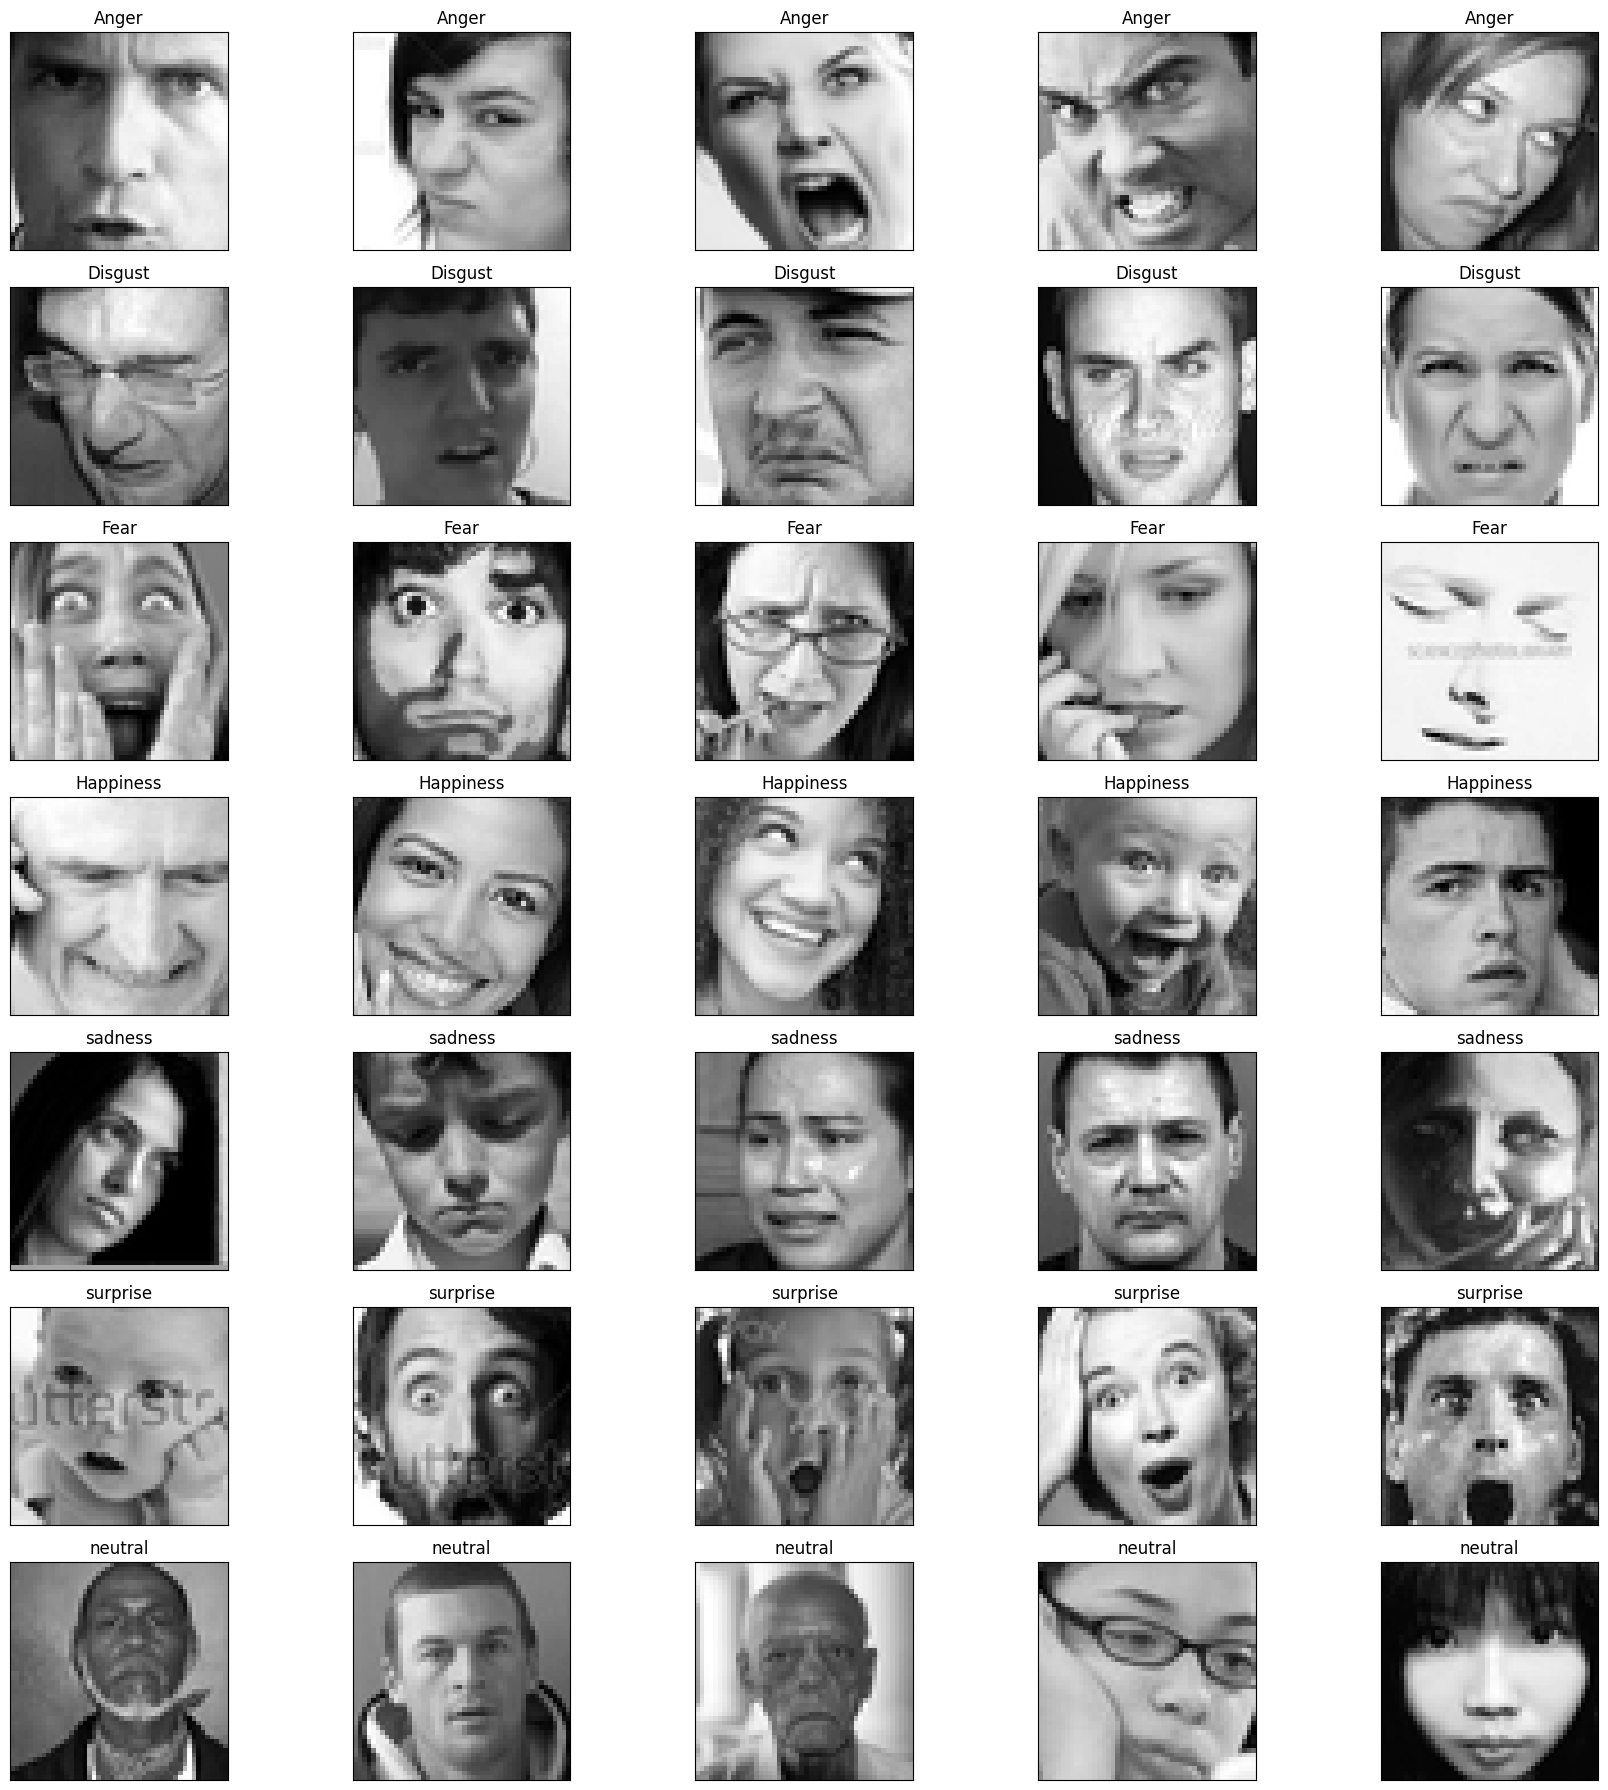

In [7]:
show_clean_samples(clean_df, label_to_text, n_samples=5)

## Số lượng emotion ở mỗi class

In [8]:
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [9]:
# Split the data into features and target variable

X_data = df['pixels']
y_data = df['emotion']

In [10]:
df.isnull().sum()

emotion         0
pixels          0
Usage           0
pixels_array    0
pixel_mean      0
pixel_std       0
pixel_min       0
pixel_max       0
is_blurred      0
is_noisy        0
corrupted       0
z_mean          0
z_std           0
is_outlier      0
dtype: int64

In [11]:
X_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 35887, dtype: object

In [12]:
# Normalize the data
x_data = np.array(list(map(str.split, X_data)), np.float32)
x_data

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]], dtype=float32)

In [13]:
x_data = x_data/255

In [14]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(35887, 48, 48, 1)

In [15]:
# Split the data into train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= 0.2, random_state = 42)

In [16]:
x_train.shape, x_test.shape, y_train.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709,))

In [17]:
from keras.utils import to_categorical

2025-07-14 06:13:05.699909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752473586.030255      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752473586.132245      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# Perfom one-hot encoding on labels
y_train_encoded = to_categorical(y_train, 7)
y_train_encoded.shape

(28709, 7)

In [19]:
y_test_encoded = to_categorical(y_test, 7)
y_test_encoded.shape

(7178, 7)

In [20]:
x_data_rgb = np.repeat(x_data, 3, axis=-1)  # chuyển (48, 48, 1) → (48, 48, 3)


In [21]:
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)


In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
class FERCSV_Dataset(Dataset):
    def __init__(self, csv_path, usage="Training", transform=None, image_size=384):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = int(row['emotion'])
        pixels = np.fromstring(row['pixels'], dtype=np.uint8, sep=' ').reshape(48, 48)
        # Resize & chuyển sang RGB
        # Do mô hình EfficientNet-V2s yêu cầu 3 kênh (3x384x384) -> Chuyển ảnh xám sang RGB để đáp ứng yêu cầu của model
        image = cv2.resize(pixels, (self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        return image, label

In [ ]:
import torchvision.transforms as transforms
from torchvision import transforms
def get_train_transform(image_size=384):
    return transforms.Compose([
        # 1. Resize ảnh về kích thước cố định (384x384)
        transforms.Resize((image_size, image_size)),
        # 2. Lật ngang ảnh ngẫu nhiên với xác suất 0.5
        transforms.RandomHorizontalFlip(),
        # 3. Xoay ảnh ngẫu nhiên trong khoảng ±10 độ
        transforms.RandomRotation(10),
        # 4. Cắt ngẫu nhiên ảnh lại đúng kích thước image_size với padding 10
        # -> tạo sự dịch chuyển đối tượng nhẹ trong ảnh, tăng tính bất biến vị trí
        transforms.RandomCrop(image_size, padding=10),

        # 5. Chuyển ảnh từ PIL → Tensor, đưa giá trị pixel từ [0, 255] → [0.0, 1.0]
        transforms.ToTensor(),
        # 6. Chuẩn hóa: scale dữ liệu từ [0.0, 1.0] → [-1.0, 1.0]
        # mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5] → (x - 0.5) / 0.5
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
def get_val_transform(image_size=384):
    return transforms.Compose([
        # Resize ảnh về 384x384 cố định
        transforms.Resize((image_size, image_size)),
        # Chuyển sang Tensor
        transforms.ToTensor(),
        # Chuẩn hóa giống phần training để đảm bảo nhất quán
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

In [ ]:
import numpy as np
def calculate_class_weights(dataloader):
    # Khởi tạo danh sách để chứa tất cả nhãn (labels) từ dataloader
    all_labels = []
    # Duyệt từng batch trong dataloader
    for _, labels in dataloader:
        # Chuyển tensor nhãn sang numpy array và thêm vào danh sách
        all_labels.extend(labels.numpy())
    # Đếm số lượng mẫu trong từng lớp (class)
    # class_counts[i] = số mẫu của lớp i
    class_counts = np.bincount(np.array(all_labels))
    # Tổng số mẫu trong toàn bộ tập dữ liệu
    total = len(all_labels)
    # Số lượng lớp (class)
    n_classes = len(class_counts)
    # Tính trọng số cho từng lớp:
    # weight[i] = tổng số mẫu / (số lớp × số mẫu của lớp i)
    # Điều này giúp các lớp hiếm có trọng số cao hơn
    weights = total / (n_classes * class_counts)
    # Trả về trọng số dưới dạng tensor float32 để sử dụng trong loss function
    return torch.FloatTensor(weights)



In [ ]:
from torch.utils.data import DataLoader
def get_train_val_loaders_from_csv(csv_path, batch_size=8, image_size=384, num_workers=4):
    # Tạo Dataset cho tập huấn luyện từ CSV, chỉ lấy các dòng có Usage == "Training"
    train_dataset = FERCSV_Dataset(
        csv_path=csv_path,
        usage="Training",  # lọc ảnh dùng cho huấn luyện
        transform=get_train_transform(image_size),  # áp dụng transform có augmentation
        image_size=image_size
    )
    # Tạo Dataset cho tập validation, lấy các dòng có Usage == "PublicTest"
    val_dataset = FERCSV_Dataset(
        csv_path=csv_path,
        usage="PublicTest",  # lọc ảnh dùng để đánh giá
        transform=get_val_transform(image_size),  # transform không có augmentation
        image_size=image_size
    )
    # Tạo DataLoader cho tập huấn luyện
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,  # số lượng ảnh mỗi batch
        shuffle=True,           # shuffle dữ liệu huấn luyện
        num_workers=num_workers # số luồng load dữ liệu (tăng tốc)
    )
    # Tạo DataLoader cho tập validation
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,  # giữ nguyên batch size
        shuffle=False,          # không shuffle để đánh giá ổn định
        num_workers=num_workers
    )
    # Trả về 2 DataLoader
    return train_loader, val_loader

In [ ]:
import torch
import torch.nn.functional as F
def mixup_data(x, y, alpha=1.0):
    """Trộn dữ liệu đầu vào và nhãn bằng Mixup.
    Mixup giúp tăng biến thể đầu vào (dữ liệu ảo)
    Mixup giúp cho mô hình không bị lệ thuộc quá chi tiết vào từng ảnh gốc
    Nếu lamdba >0, lấy hệ số lambda từ phân phối Beta(alpha,apha)
    Note: Không mixup nếu alpha bằng 0
    """
    if alpha > 0:
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        lam = 1.0
    batch_size = x.size(0) # Lấy kích thước batch hiện tại
    # # Tạo một hoán vị ngẫu nhiên chỉ số trong batch
    index = torch.randperm(batch_size)
    # Trộn ảnh đầu vào theo công thức: x̃ = λ*x + (1−λ)*x′
    mixed_x = lam * x + (1 - lam) * x[index, :]
    #Nhãn gốc và nhãn bị trộn tương ứng
    y_a, y_b = y, y[index]
    #Trả về 2 ảnh trộn, 2 nhãn và hệ số lambda
    return mixed_x, y_a, y_b, lam

In [ ]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Tính toán loss cho dữ liệu đã áp dụng Mixup.

    Parameters:
    - criterion: hàm loss gốc, ví dụ nn.CrossEntropyLoss()
    - pred: đầu ra (logits) từ model, shape (batch_size, num_classes)
    - y_a: nhãn gốc (labels ban đầu), shape (batch_size,)
    - y_b: nhãn bị trộn (labels của ảnh hoán vị), shape (batch_size,)
    - lam: hệ số Mixup λ ∈ (0, 1), càng gần 1 thì thiên về nhãn y_a

    Returns:
    - loss_mixup: giá trị loss kết hợp giữa y_a và y_b theo hệ số lam
    """
    # Tính loss với nhãn gốc y_a, rồi nhân với λ
    loss_a = lam * criterion(pred, y_a)
    # Tính loss với nhãn đã hoán vị y_b, nhân với (1 - λ)
    loss_b = (1 - lam) * criterion(pred, y_b)
    # Tổng hợp lại thành loss Mixup cuối cùng
    return loss_a + loss_b

In [28]:
csv_path = "/kaggle/working/fer2013_new.csv"
train_loader, val_loader = get_train_val_loaders_from_csv(csv_path)


In [ ]:
test_dataset = FERCSV_Dataset(
    csv_path=csv_path,                 # Đường dẫn đến file CSV chứa dữ liệu (ví dụ: fer2013_new.csv)
    usage="PrivateTest",               # Lọc các dòng có Usage == "PrivateTest"
    transform=get_val_transform()      # Sử dụng transform như trong validation (không augmentation)
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,                      # Dataset vừa tạo
    batch_size=8,                      # Số ảnh mỗi batch
    shuffle=False                      # Không shuffle → giữ thứ tự để so sánh từng ảnh nếu cần
)

## Model 

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('efficientnetv2_s', pretrained=False, num_classes=7)
model = model.to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [32]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            print(f" EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [ ]:
from tqdm import tqdm
# === Hàm evaluate: dùng để đánh giá model trên tập validation ===
def evaluate(model, data_loader, loss_fn, device):
    model.eval()  # Bật chế độ đánh giá: tắt dropout, batchnorm dùng moving average
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tăng tốc
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)               # Dự đoán đầu ra
            loss = loss_fn(outputs, labels)       # Tính loss

            total_loss += loss.item() * images.size(0)  # Tích lũy tổng loss
            _, predicted = torch.max(outputs, 1)        # Lấy nhãn dự đoán (class có xác suất cao nhất)
            correct += (predicted == labels).sum().item()  # Đếm số ảnh đúng
            total += labels.size(0)  # Tổng số ảnh

    avg_loss = total_loss / total  # Tính loss trung bình
    accuracy = correct / total     # Tính accuracy
    return avg_loss, accuracy
# Dictionary để lưu lại loss và accuracy qua từng epoch
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
num_epochs = 100  # Số vòng huấn luyện tối đa
# Tối ưu Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler giảm LR khi val_loss không giảm
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
# Cơ chế dừng sớm khi không cải thiện validation loss trong nhiều epoch
early_stopping = EarlyStopping(patience=8)
for epoch in range(num_epochs):
    model.train()  # Bật chế độ huấn luyện
    running_loss = 0.0
    correct = 0
    total = 0
    # In learning rate hiện tại
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1} — Current LR: {current_lr:.6f}")
    # Thanh tiến trình TQDM
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        # === Tăng cường dữ liệu bằng Mixup ===
        images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.4)
        # Backpropagation
        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        loss.backward()
        optimizer.step()
        # Dự đoán lớp (không áp dụng mixup ở đây để tính acc cho dễ)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Tính tổng loss
        running_loss += loss.item() * images.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        # Hiển thị loss và acc tạm thời
        loop.set_postfix(loss=train_loss, acc=train_acc)
    # === Validation ===
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    # Hiển thị kết quả validation ngay trên thanh tiến trình
    loop.set_postfix({
        'loss': train_loss,
        'acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    })
    # Lưu lại lịch sử
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    scheduler.step(val_loss)  # Giảm LR nếu val_loss không giảm
    early_stopping(val_loss)  # Kiểm tra xem có nên dừng sớm không
    if early_stopping.early_stop:
        print("Early stopping triggered.")  # In ra thông báo dừng
        break


Epoch 1 — Current LR: 0.001000


Epoch 1/100 [Train]: 100%|██████████| 3514/3514 [15:38<00:00,  3.74it/s, acc=0.242, loss=1.8]


Validation Loss: 1.5613, Accuracy: 0.3713

Epoch 2 — Current LR: 0.001000


Epoch 2/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.313, loss=1.58]


Validation Loss: 1.4312, Accuracy: 0.4567

Epoch 3 — Current LR: 0.001000


Epoch 3/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.344, loss=1.48]


Validation Loss: 1.2719, Accuracy: 0.5047

Epoch 4 — Current LR: 0.001000


Epoch 4/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.363, loss=1.42]


Validation Loss: 1.1978, Accuracy: 0.5577

Epoch 5 — Current LR: 0.001000


Epoch 5/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.379, loss=1.37]


Validation Loss: 1.1796, Accuracy: 0.5501

Epoch 6 — Current LR: 0.001000


Epoch 6/100 [Train]: 100%|██████████| 3514/3514 [15:43<00:00,  3.72it/s, acc=0.391, loss=1.34]


Validation Loss: 1.1102, Accuracy: 0.5722

Epoch 7 — Current LR: 0.001000


Epoch 7/100 [Train]: 100%|██████████| 3514/3514 [15:42<00:00,  3.73it/s, acc=0.404, loss=1.31]


Validation Loss: 1.0948, Accuracy: 0.5943

Epoch 8 — Current LR: 0.001000


Epoch 8/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.41, loss=1.29]


Validation Loss: 1.0873, Accuracy: 0.5963

Epoch 9 — Current LR: 0.001000


Epoch 9/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.73it/s, acc=0.409, loss=1.27]


Validation Loss: 1.0566, Accuracy: 0.6068

Epoch 10 — Current LR: 0.001000


Epoch 10/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.424, loss=1.25]


Validation Loss: 1.0261, Accuracy: 0.6148

Epoch 11 — Current LR: 0.001000


Epoch 11/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.419, loss=1.22]


Validation Loss: 1.0402, Accuracy: 0.6139
 EarlyStopping counter: 1/8

Epoch 12 — Current LR: 0.001000


Epoch 12/100 [Train]: 100%|██████████| 3514/3514 [15:42<00:00,  3.73it/s, acc=0.432, loss=1.22]


Validation Loss: 1.0519, Accuracy: 0.6082
 EarlyStopping counter: 2/8

Epoch 13 — Current LR: 0.001000


Epoch 13/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.431, loss=1.2]


Validation Loss: 1.0133, Accuracy: 0.6199

Epoch 14 — Current LR: 0.001000


Epoch 14/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.441, loss=1.19]


Validation Loss: 0.9943, Accuracy: 0.6278

Epoch 15 — Current LR: 0.001000


Epoch 15/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.437, loss=1.19]


Validation Loss: 0.9957, Accuracy: 0.6235
 EarlyStopping counter: 1/8

Epoch 16 — Current LR: 0.001000


Epoch 16/100 [Train]: 100%|██████████| 3514/3514 [15:42<00:00,  3.73it/s, acc=0.439, loss=1.18]


Validation Loss: 0.9814, Accuracy: 0.6264

Epoch 17 — Current LR: 0.001000


Epoch 17/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.448, loss=1.16]


Validation Loss: 0.9791, Accuracy: 0.6411

Epoch 18 — Current LR: 0.001000


Epoch 18/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.447, loss=1.15]


Validation Loss: 1.0083, Accuracy: 0.6363
 EarlyStopping counter: 1/8

Epoch 19 — Current LR: 0.001000


Epoch 19/100 [Train]: 100%|██████████| 3514/3514 [15:42<00:00,  3.73it/s, acc=0.45, loss=1.14]


Validation Loss: 0.9968, Accuracy: 0.6272
 EarlyStopping counter: 2/8

Epoch 20 — Current LR: 0.001000


Epoch 20/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.452, loss=1.13]


Validation Loss: 0.9833, Accuracy: 0.6397
 EarlyStopping counter: 3/8

Epoch 21 — Current LR: 0.000500


Epoch 21/100 [Train]: 100%|██████████| 3514/3514 [15:39<00:00,  3.74it/s, acc=0.469, loss=1.08]


Validation Loss: 0.9102, Accuracy: 0.6582

Epoch 22 — Current LR: 0.000500


Epoch 22/100 [Train]: 100%|██████████| 3514/3514 [15:39<00:00,  3.74it/s, acc=0.461, loss=1.07]


Validation Loss: 0.9117, Accuracy: 0.6613
 EarlyStopping counter: 1/8

Epoch 23 — Current LR: 0.000500


Epoch 23/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.465, loss=1.06]


Validation Loss: 0.9134, Accuracy: 0.6670
 EarlyStopping counter: 2/8

Epoch 24 — Current LR: 0.000500


Epoch 24/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.476, loss=1.05]


Validation Loss: 0.9076, Accuracy: 0.6684

Epoch 25 — Current LR: 0.000500


Epoch 25/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.478, loss=1.04]


Validation Loss: 0.9057, Accuracy: 0.6664

Epoch 26 — Current LR: 0.000500


Epoch 26/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.73it/s, acc=0.483, loss=1.03]


Validation Loss: 0.9063, Accuracy: 0.6664
 EarlyStopping counter: 1/8

Epoch 27 — Current LR: 0.000500


Epoch 27/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.477, loss=1.01]


Validation Loss: 0.9088, Accuracy: 0.6704
 EarlyStopping counter: 2/8

Epoch 28 — Current LR: 0.000500


Epoch 28/100 [Train]: 100%|██████████| 3514/3514 [15:39<00:00,  3.74it/s, acc=0.482, loss=1.01]


Validation Loss: 0.9010, Accuracy: 0.6664

Epoch 29 — Current LR: 0.000500


Epoch 29/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.495, loss=1.01]


Validation Loss: 0.8916, Accuracy: 0.6760

Epoch 30 — Current LR: 0.000500


Epoch 30/100 [Train]: 100%|██████████| 3514/3514 [15:42<00:00,  3.73it/s, acc=0.49, loss=0.998]


Validation Loss: 0.9112, Accuracy: 0.6644
 EarlyStopping counter: 1/8

Epoch 31 — Current LR: 0.000500


Epoch 31/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.493, loss=0.995]


Validation Loss: 0.9144, Accuracy: 0.6655
 EarlyStopping counter: 2/8

Epoch 32 — Current LR: 0.000500


Epoch 32/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.486, loss=0.989]


Validation Loss: 0.9115, Accuracy: 0.6791
 EarlyStopping counter: 3/8

Epoch 33 — Current LR: 0.000250


Epoch 33/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.504, loss=0.95]


Validation Loss: 0.9033, Accuracy: 0.6755
 EarlyStopping counter: 4/8

Epoch 34 — Current LR: 0.000250


Epoch 34/100 [Train]: 100%|██████████| 3514/3514 [15:41<00:00,  3.73it/s, acc=0.51, loss=0.925]


Validation Loss: 0.8923, Accuracy: 0.6854
 EarlyStopping counter: 5/8

Epoch 35 — Current LR: 0.000250


Epoch 35/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.504, loss=0.923]


Validation Loss: 0.8997, Accuracy: 0.6851
 EarlyStopping counter: 6/8

Epoch 36 — Current LR: 0.000125


Epoch 36/100 [Train]: 100%|██████████| 3514/3514 [15:39<00:00,  3.74it/s, acc=0.517, loss=0.91]


Validation Loss: 0.8942, Accuracy: 0.6885
 EarlyStopping counter: 7/8

Epoch 37 — Current LR: 0.000125


Epoch 37/100 [Train]: 100%|██████████| 3514/3514 [15:40<00:00,  3.74it/s, acc=0.513, loss=0.909]


Validation Loss: 0.9012, Accuracy: 0.6851
 EarlyStopping counter: 8/8
Early stopping triggered.


## Đánh giá trên tập test

In [34]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.8507
Test Accuracy: 0.7023


## Biểu đồ sau khi huấn luyện 

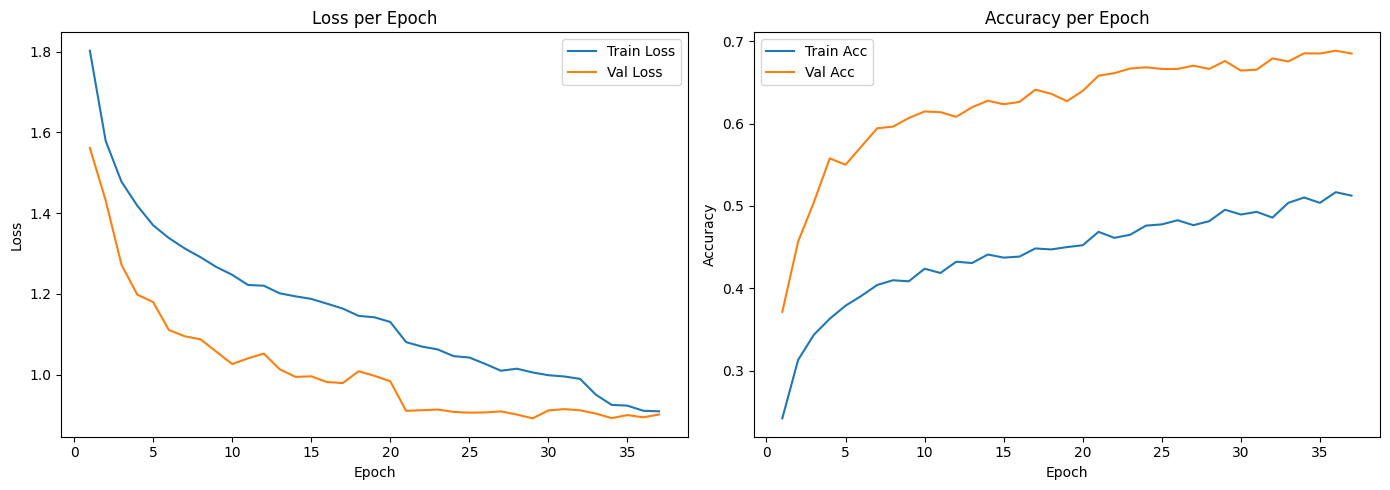

In [35]:
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


## Ma trận nhầm lẫn


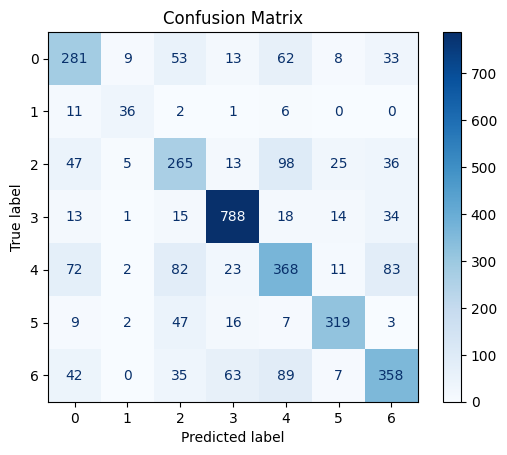

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Dự đoán trên tập validation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## Predict ảnh sau khi test

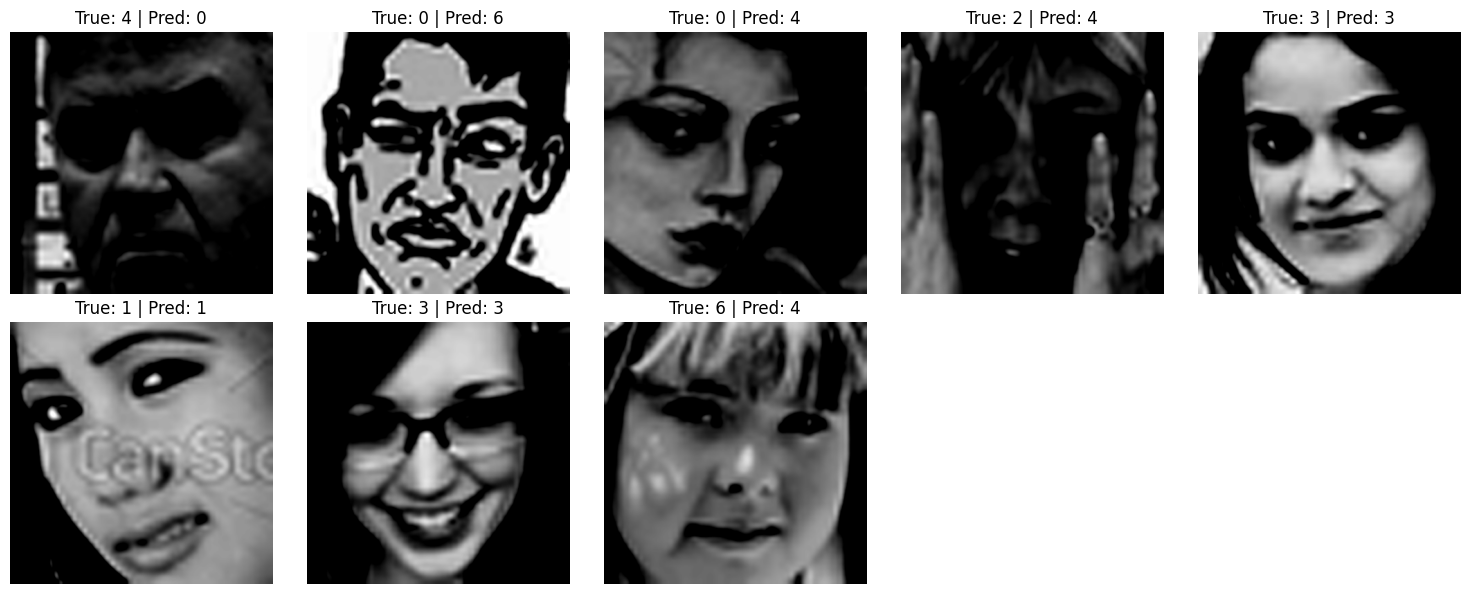

In [37]:
import matplotlib.pyplot as plt
import random
import torch

# Đặt model về chế độ đánh giá
model.eval()

# Lấy 1 batch từ val_loader
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Dự đoán
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Chọn ngẫu nhiên 10 ảnh (hoặc ít hơn nếu batch < 10)
num_samples = min(10, len(images))
indices = random.sample(range(len(images)), num_samples)

# Hiển thị ảnh
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    image = images[idx].cpu()
    true_label = labels[idx].item()
    predicted_label = preds[idx].item()

    # Chuyển về HWC nếu có 3 kênh
    if image.shape[0] == 3:
        image = image.permute(1, 2, 0)
    elif image.shape[0] == 1:  # Nếu là ảnh xám
        image = image.squeeze(0)

    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Lưu model

In [38]:
torch.save(model.state_dict(),"Final_Project_DPL302m_Efficientnet-v2s.h5")
print(" Hoàn tất ")

 Hoàn tất 
